In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Jun  1 17:45:41 2020

@author: mahyarfazlyab
"""

# import sys
# sys.path.append("../Python/")

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.io import loadmat
import scipy.io
import os
import pickle
import matplotlib.pyplot as plt
from NeuralNetwork import NeuralNetwork



def export2matlab(file_name, net, A, B, save_model=False):
    '''
    Export pytorch fully connected network to matlab

    '''

    num_layers = int((len(net) - 1) / 2)
    dim_in = float(net[0].weight.shape[1])
    dim_out = float(net[-1].weight.shape[0])
    hidden_dims = [float(net[2 * i].weight.shape[0]) for i in range(0, num_layers)]

    # network dimensions
    dims = [dim_in] + hidden_dims + [dim_out]

    # get weights
    # weights = np.zeros((num_layers+1,))
    weights = [net[2 * i].weight.detach().numpy().astype(np.float64) for i in range(0, num_layers + 1)]

    # get biases
    # biases = np.zeros((num_layers+1,))
    biases = [net[2 * i].bias.detach().numpy().astype(np.float64).reshape(-1, 1) for i in range(0, num_layers + 1)]

    activation = str(net[1])[0:-2].lower()

    # export network data to matlab
    data = {}
    data['net'] = {'weights': weights, 'biases': biases, 'dims': dims, 'activation': activation, 'name': file_name}
    data['AMatrix'] = A
    data['BMatrix'] = B


    scipy.io.savemat(file_name + '.mat', data)





`polytope` failed to import `cvxopt.glpk`.
will use `scipy.optimize.linprog`


In [10]:
device = torch.device("cuda:0")
trainCompleteLoop = True
# with open('xs.pkl', 'rb') as f:
#     Xtrain = pickle.load(f)
#
# with open('us.pkl', 'rb') as f:
#     Ytrain = pickle.load(f)

data = loadmat("trainDataQuad.mat")
XFull = data['X']
YFull = data['y']
# data = loadmat("quadRotorTrainData.mat")
# Xtrain = data['Xtrain']
# Ytrain = data['Ytrain']
# A = data['A']
# B = data['B']
if True:
    A = np.zeros((6, 6))
    A[0, 3] = 1
    A[1, 4] = 1
    A[2, 5] = 1

    B = np.zeros((6, 3))
    B[3, 0] =  9.8
    B[4, 1] = -9.8
    B[5, 2] =  1

    C = np.zeros((6, 1))
    C[5] = -9.8

    A = np.eye(6) + A * 0.1
    B = B * 0.1
    C = C * 0.1

else:
    A = np.array([[1, 1], [0, 1]])
    B = np.array([[0.5], [1]])
lastDim = 3
if trainCompleteLoop:
    YFull = (A @ XFull.T + B @ YFull.T + C).T
    lastDim = 6

# print(torch.linalg.norm(torch.Tensor(B)), torch.linalg.norm(torch.Tensor(A)))
# raise
# print(A)
# print(B)
# print(Xtrain.shape)
# print(Ytrain.shape)
dataSplit = 0.9
trainSize = int(dataSplit * XFull.shape[0])

trainset, testSet = torch.utils.data.random_split(torch.utils.data.TensorDataset(torch.Tensor(XFull), torch.Tensor(YFull)), [trainSize, XFull.shape[0] - trainSize])

net = nn.Sequential(
    nn.Linear(6, 64),
    nn.ReLU(),
    nn.Linear(64, 48),
    nn.ReLU(),
    nn.Linear(48, 32),
    nn.ReLU(),
    nn.Linear(32, lastDim))
net.to(device)
train_batch_size = 128
trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size, shuffle=True,
                                          num_workers=2)
testLoader = torch.utils.data.DataLoader(testSet, batch_size=train_batch_size, num_workers=2)
epoch = 400
net.train()
trainLosses = []
validationLosses = []

def my_loss(output, target):
    gamma = 0.
    loss = torch.mean((output - target)**2) \
           + gamma * torch.linalg.norm(net[-1].weight) \
                                                * torch.linalg.norm(net[-3].weight) \
                                                * torch.linalg.norm(net[-5].weight)
    return loss
bestStateDic = None
bestLoss = 100000
criterion = my_loss
optimizer = optim.Adam(net.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)

lambdaVal = torch.Tensor([1.2]).to(device)
loaders = {"train": trainloader, "eval": testLoader}
for t in range(epoch):
    for phase in {"train", 'eval'}:
        if phase == "train":
            net.train()
        else:
            net.eval()
        tempValidationLosses = []
        for i, (X, Y) in enumerate(loaders[phase]):
            X = X.to(device)
            Y = Y.to(device)
            out = net(X)
            loss = criterion(out, Y)

            if phase == "train":
                loss.backward()
                optimizer.step()

                with torch.no_grad():
                    optimizer.zero_grad()
                    for i in [0, 2, 4]:
                        net[i].weight /= torch.maximum(torch.tensor([1.]).to(device), (torch.linalg.norm(net[i].weight) / lambdaVal))
            else:
                tempValidationLosses.append(loss)
                if loss < bestLoss:
                    bestLoss = loss
                    bestStateDic = net.state_dict()
                    torch.save(bestStateDic, "tempBestStateDict.pth")
        if phase == "train":
            scheduler.step()
            trainLosses.append(loss.item())
        else:
            validationLosses.append(sum(tempValidationLosses[:-1]) / (len(tempValidationLosses) - 1))
        if np.mod(t, 10) == 0:
            print("epoch:", t)
            if phase == "train":
                print('MSE loss: ', loss.item(), ", Norm of product:", torch.linalg.norm(net[0].weight) * torch.linalg.norm(net[2].weight) * torch.linalg.norm(net[4].weight))
            else:
                print("validation losses average: ", validationLosses[-1])






epoch: 0
validation losses average:  tensor(4.3383, device='cuda:0', grad_fn=<DivBackward0>)
epoch: 0
MSE loss:  3.788944959640503 , Norm of product: tensor(1.7280, device='cuda:0', grad_fn=<MulBackward0>)
epoch: 10
validation losses average:  tensor(0.2027, device='cuda:0', grad_fn=<DivBackward0>)
epoch: 10
MSE loss:  0.16986989974975586 , Norm of product: tensor(1.7280, device='cuda:0', grad_fn=<MulBackward0>)
epoch: 20
validation losses average:  tensor(0.1160, device='cuda:0', grad_fn=<DivBackward0>)
epoch: 20
MSE loss:  0.13359017670154572 , Norm of product: tensor(1.7280, device='cuda:0', grad_fn=<MulBackward0>)
epoch: 30
validation losses average:  tensor(0.1136, device='cuda:0', grad_fn=<DivBackward0>)
epoch: 30
MSE loss:  0.11146490275859833 , Norm of product: tensor(1.7280, device='cuda:0', grad_fn=<MulBackward0>)
epoch: 40
validation losses average:  tensor(0.1127, device='cuda:0', grad_fn=<DivBackward0>)
epoch: 40
MSE loss:  0.11161177605390549 , Norm of product: tensor(1.7

In [11]:
print("best loss: ", bestLoss)
net.load_state_dict(bestStateDic)
layers = []
dimensions = [net[0].weight.shape[1]]
for i in range(len(net)):
    if i % 2 == 0:
        dimensions.append(net[i].weight.shape[0])
for i in range(len(dimensions) - 1):
    layers.append(nn.Linear(dimensions[i], dimensions[i + 1]))
    if i < len(dimensions) - 2:
        layers.append(nn.ReLU())
network = nn.Sequential(*layers)
networkClass = NeuralNetwork("../randomNetwork.pth")

networkClass.Linear = network
torch.save(networkClass.state_dict(), "../quadRotorFullLoopV1.2.pth")

best loss:  tensor(0.0848, device='cuda:0', grad_fn=<AddBackward0>)


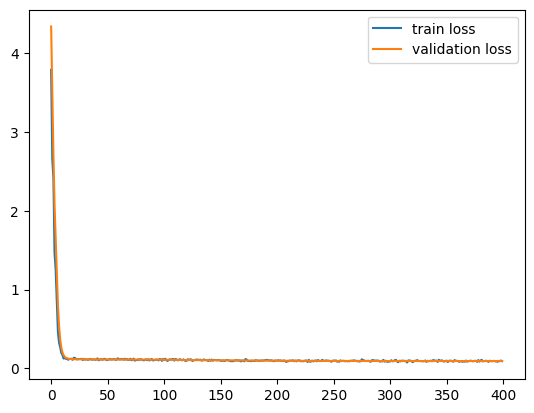

In [12]:
plt.plot(trainLosses)
plt.plot([validationLoss.item() for validationLoss in validationLosses])
plt.legend(["train loss", "validation loss"])

In [3]:
len(net)

7

(11457, 6)